# Обучение pipline модели

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
from lightgbm import LGBMClassifier

In [3]:
from sklearn.metrics import roc_auc_score

In [4]:
import joblib

In [5]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [8]:
import shap
import matplotlib.pyplot as plt

In [28]:
import yaml

## Загрузка датасета

In [9]:
app_info_df = pd.read_csv("application_info.csv")
dflt_flg_df = pd.read_csv("default_flg.csv")

In [10]:
app_info_df_for_convert = app_info_df.drop(columns=["sample_cd"])

In [11]:
merge_df = pd.merge(app_info_df, dflt_flg_df, how='inner')

In [12]:
merge_df = merge_df.drop(columns=["sample_cd", "id"])

In [13]:
X, y = merge_df.drop(columns=["default_flg"]), merge_df.default_flg

In [14]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y, test_size=0.40, random_state=42, shuffle=True)

In [15]:
X_val, y_val = X_val_test.iloc[22032:], y_val_test.iloc[22032:]
X_test, y_test = X_val_test.iloc[0:22031], y_val_test.iloc[0:22031]

In [16]:
merge_df.columns.to_list()

['application_dt',
 'education_cd',
 'gender_cd',
 'age',
 'car_own_flg',
 'car_type_flg',
 'appl_rej_cnt',
 'good_work_flg',
 'Score_bki',
 'out_request_cnt',
 'region_rating',
 'home_address_cd',
 'work_address_cd',
 'income',
 'SNA',
 'first_time_cd',
 'Air_flg',
 'default_flg']

In [139]:
date_col = "application_dt"
onehot_cols = ["education_cd", "gender_cd", "car_own_flg", "car_type_flg", "Air_flg", 'season']
passthrough_cols = ['good_work_flg', 'Score_bki', 'home_address_cd', 'work_address_cd', 'SNA', 'first_time_cd', 'quarter']
std_scale_cols = ['age', 'income', 'region_rating']
outlier_cols = [("out_request_cnt", 10), ("appl_rej_cnt", 5)]

## Доп функции для преобразования данных

In [140]:
# Простой трансформер для времени
class TimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, date_col='application_dt'):
        self.date_col = date_col  # Название колонки с датой
    
    def fit(self, X, y=None):
        return self  # Ничего не учим, просто преобразуем
    
    def transform(self, X):
        df_temp = X.copy()
        
        if self.date_col in df_temp.columns:
            dates = pd.to_datetime(df_temp[self.date_col], format='%d%b%Y')
            month = dates.dt.month
            
            # ОСТАВЛЯЕМ ТОЛЬКО ВАЖНЫЕ:
            # 2. Сезон 
            df_temp['season'] = month.apply(self._get_season)
            
            # 2. Квартал года
            df_temp['quarter'] = dates.dt.quarter  # 1-4
            
            # Удаляем исходную дату
            df_temp = df_temp.drop(self.date_col, axis=1)
        
        return df_temp
    
    def _get_season(self, month):
        """Определяем сезон по месяцу"""
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:  # 9, 10, 11
            return 'autumn'

In [141]:
class OutlierTransformer(BaseEstimator, TransformerMixin):
    """Трансформер для обработки колонок с выбросами"""
    
    def __init__(self, conditions: list[tuple[str, int]]):
        self.conditions = conditions
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df_temp = X.copy()
        for condition in self.conditions:
            column, num = condition[0], condition[1] 
            if column in df_temp.columns:
                df_temp[f'{column}_gt_{num}'] = (df_temp[column] > num).astype(int)
                df_temp = df_temp.drop(column, axis=1)
        
        return df_temp

## Model pipline

In [142]:
# Трансформер для one-hot кодирования
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])
# Трансформер для нормализации данных
scale_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [143]:
# Собираем все вместе
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', onehot_transformer, onehot_cols),
        ('scaler', scale_transformer, std_scale_cols),
        ('passthrough', 'passthrough', passthrough_cols)
    ]
).set_output(transform="pandas")

In [144]:
best_params = {'n_estimators': 406, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 15, 'scale_pos_weight': 11.135712739455382, 'reg_alpha': 0.0014341754109660826, 'reg_lambda': 0.5210082757225214, 'learning_rate': 0.047127077338180494, 'subsample': 0.8230729607127126, 'colsample_bytree': 0.6525305504945635, 'subsample_freq': 2}

In [145]:
model_pipeline = Pipeline(steps=[
    ('outliers', OutlierTransformer(conditions=outlier_cols)),
    ('time_transform', TimeTransformer(date_col=date_col)),
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(**best_params))
])

## Обучение модели и вывод метрик

In [146]:
model_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 12519, number of negative: 95970
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 602
[LightGBM] [Info] Number of data points in the train set: 108489, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115394 -> initscore=-2.036788
[LightGBM] [Info] Start training from score -2.036788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

,steps,"[('outliers', ...), ('time_transform', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,conditions,"[('out_request_cnt', ...), ('appl_rej_cnt', ...)]"
,date_col,'application_dt'
,transformers,"[('onehot', ...), ('scaler', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None


In [147]:
test_rocauc_score = roc_auc_score(y_test, model_pipeline.predict_proba(X_test)[:, 1])
print(f"Test AUC: {test_rocauc_score:.3f}")

Test AUC: 0.726


In [148]:
val_rocauc_score = roc_auc_score(y_val, model_pipeline.predict_proba(X_val)[:, 1])
print(f"Val AUC: {val_rocauc_score:.3f}")

Val AUC: 0.727


In [149]:
train_rocauc_score = roc_auc_score(y_train, model_pipeline.predict_proba(X_train)[:, 1])
print(f"Train AUC: {train_rocauc_score:.3f}")

Train AUC: 0.745


## Вывод важности признаков

In [150]:
lgb_model = model_pipeline.named_steps['classifier']

In [151]:
transformed_data = X_test.copy(deep=True)

In [152]:
for step_name, transformer in model_pipeline.steps[:-1]:
    transformed_data = transformer.transform(transformed_data)

In [153]:
transformed_data.columns.tolist()

['onehot__education_cd_GRD',
 'onehot__education_cd_PGR',
 'onehot__education_cd_SCH',
 'onehot__education_cd_UGR',
 'onehot__gender_cd_M',
 'onehot__car_own_flg_Y',
 'onehot__car_type_flg_Y',
 'onehot__Air_flg_Y',
 'onehot__season_summer',
 'onehot__season_winter',
 'scaler__age',
 'scaler__income',
 'scaler__region_rating',
 'passthrough__good_work_flg',
 'passthrough__Score_bki',
 'passthrough__home_address_cd',
 'passthrough__work_address_cd',
 'passthrough__SNA',
 'passthrough__first_time_cd',
 'passthrough__quarter']

In [154]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(transformed_data)

D:\Programs\Anaconda\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


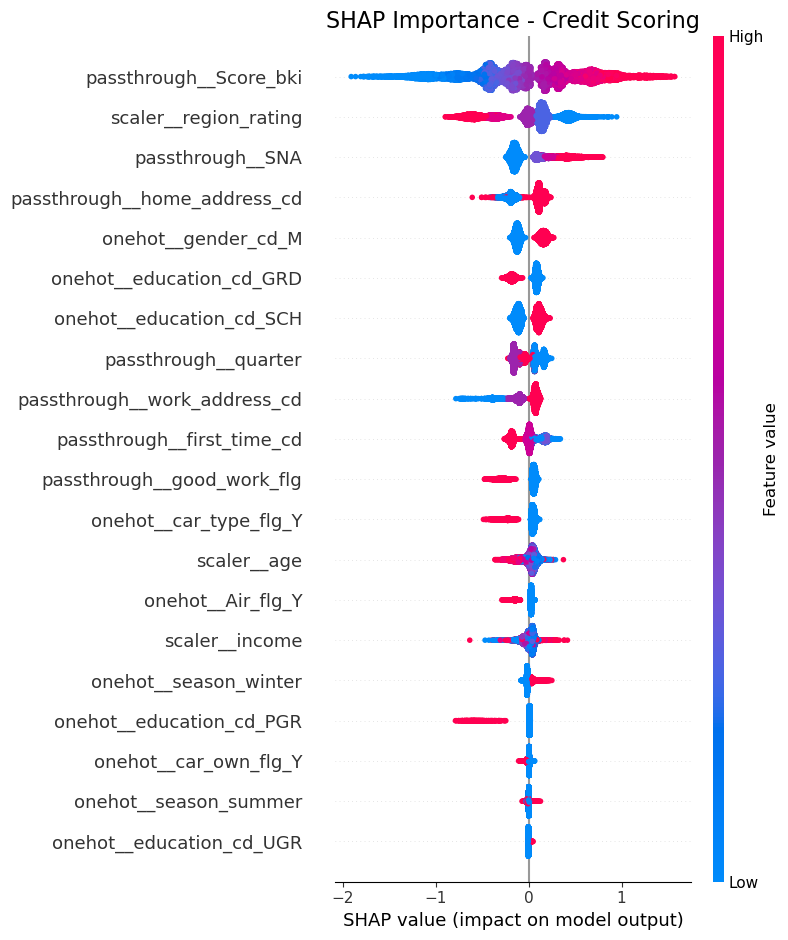

In [155]:
plt.figure(figsize=(12, 8))

# Для бинарной классификации shap_values может быть списком
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # берем значения для класса 1 (дефолт)

shap.summary_plot(shap_values, transformed_data, show=False)
plt.title("SHAP Importance - Credit Scoring", fontsize=16)
plt.tight_layout()
plt.show()

## Сохранение модели в yaml

In [163]:
model = {
    'file': None,
    'name': 'pipline LightGBM',
    'task': 'classification',
    'params': best_params
    
}

In [164]:
data = {
    'processed': '../data/processed/processed_df.csv',
    'raw': {
        'features': '../data/raw/application_info.csv',
        'target': '../data/raw/default_flg.csv'
    },
    'value_counts': {
        'class 0': 159982,
        'class 1': 20834
    }
}

In [165]:
evaluate = {
    'train_roc-auc': 0.745,
    'validation_roc-auc': 0.727,
    'test_roc-auc': 0.726,
}

In [166]:
information = {
    "model_type": "pipeline",
    "version": "1.0.1",
    "created_at": "2025-08-12",
    "author": "Golik Dmitry",
}

In [167]:
config = {
    'information': information,
    'model': model,
    'data': data,
    'evaluate': evaluate
}

In [168]:
with open('model_config_1_0_1.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(config, f, default_flow_style=False, allow_unicode=True)

## Сохрание модели в pkl

In [156]:
import joblib

In [157]:
joblib.dump(model_pipeline, 'pipline_model_3.pkl')

['pipline_model_3.pkl']

## Сохрание датасета в sql базе данных

In [8]:
from sqlalchemy import create_engine

In [9]:
engine = create_engine('sqlite:///applications.db')

In [23]:
merge_df.to_sql('applications_database', con=engine, if_exists='append', index=True, index_label='ID')

180816

In [10]:
app_info_df_for_convert.to_sql(
    name='applications_database',
    con=engine,            # соединение
    if_exists='replace',   # что делать если таблица существует
    index=False
)

205296